# Extracting Functional Connectivity Matrix from Empirical Data

Following Nilearn tutorial found at: https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py

In [2]:
import pandas as pd
import numpy as np 

from nilearn import plotting
from nilearn import image

from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiLabelsMasker

In [3]:
# ATLAS_FILE_PATH = "../../data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz"
FMRI_FILE_PATH = "../../data/adni/sub-ADNI002S0295/ses-M060/func/sub-ADNI002S0295_ses-M060_task-rest_space-MNI152Lin_res-2_desc-preproc_bold.nii.gz"
CONFOUNDS_FILE_PATH = "../../data/adni/sub-ADNI002S0295/ses-M060/func/sub-ADNI002S0295_ses-M060_task-rest_desc-confounds_timeseries.tsv"

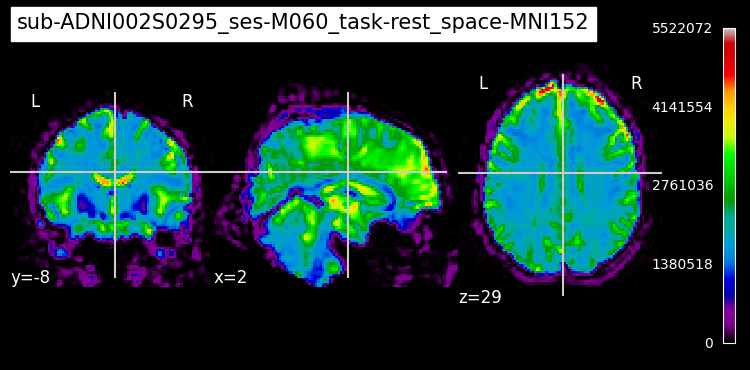

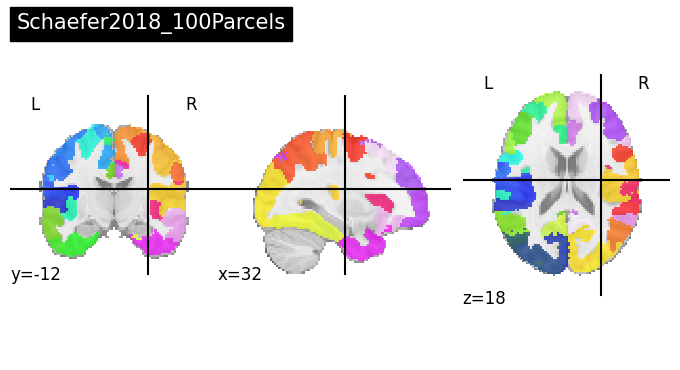

In [4]:
# Retrieve Schaefer Atlas
from nilearn import datasets 

atlas_dataset = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
atlas_map = atlas_dataset.maps
atlas_labels = atlas_dataset.labels

# Visualising fmri + atlas
mean_fmri = image.mean_img(FMRI_FILE_PATH)
plotting.plot_epi(mean_fmri, colorbar=True, cbar_tick_format="%i", title="sub-ADNI002S0295_ses-M060_task-rest_space-MNI152")

plotting.plot_roi(atlas_map, title="Schaefer2018_100Parcels")



In [21]:
# PREPROCESSING
# Remove NaNs from the Confound File - ignore time step 1 in fmri time series + Nifti file

df = pd.read_csv(CONFOUNDS_FILE_PATH, sep='\t')
confounds = df.values[1:]

print("The shape of the confounds matrix is:", confounds.shape)
print(df.columns)

The shape of the confounds matrix is: (139, 157)
Index(['global_signal', 'global_signal_derivative1',
       'global_signal_derivative1_power2', 'global_signal_power2', 'csf',
       'csf_derivative1', 'csf_power2', 'csf_derivative1_power2',
       'white_matter', 'white_matter_derivative1',
       ...
       'motion_outlier17', 'motion_outlier18', 'motion_outlier19',
       'motion_outlier20', 'motion_outlier21', 'motion_outlier22',
       'motion_outlier23', 'motion_outlier24', 'motion_outlier25',
       'motion_outlier26'],
      dtype='object', length=157)


In [32]:
# Extracting signals on a parcellation defined by labels

# define mask
masker = NiftiLabelsMasker(
    labels_img=atlas_map,
    standardize="zscore_sample",
    standardize_confounds=True,
    high_variance_confounds=True,
    memory="nilearn_cache",
    verbose=5,
)


[NiftiLabelsMasker.wrapped] loading data from /Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]1.7s, 0.0min    : Loading high_variance_confounds...
_____________________________high_variance_confounds cache loaded - 0.0s, 0.0min
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x28f729cd0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x28ecf8710>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': True,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  '

/Users/dyutichakraborty/Library/CloudStorage/OneDrive-Personal/University/Year 4/FYP/code/ad_modelling_fyp/nilearn/maskers/nifti_labels_masker.py:670: UserWarning: Persisting input arguments took 1.82s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  region_signals, (ids, masked_atlas) = self._cache(
/Users/dyutichakraborty/Library/CloudStorage/OneDrive-Personal/University/Year 4/FYP/code/ad_modelling_fyp/nilearn/plotting/matrix_plotting.py:137: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(mat, method=reorder)
/Users/dyutichakraborty/Library/CloudStorage/OneDrive-Personal/University/Year 4/FYP/code/ad_modelling_fyp/nilearn/plotting/matrix_plotting.py:138: ClusterWarning: The symmetric non-negative hollow observation matrix looks su

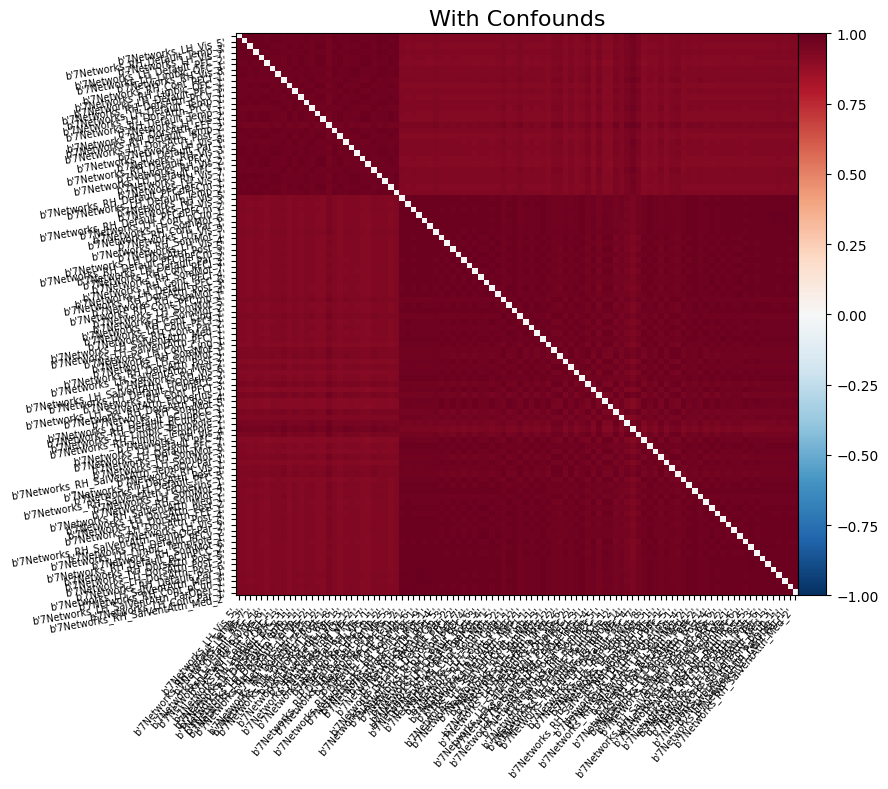

In [33]:
# Plot connectivity matrix - With Confounds

# Index the image to remove the first timestep
fmri = image.load_img(FMRI_FILE_PATH)
fmri = image.index_img(fmri, slice(1, None))

time_series = masker.fit_transform(fmri, confounds=confounds)

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

print(correlation_matrix)

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=atlas_labels,
    vmax=1,
    vmin=-1,
    title="With Confounds",
    reorder=True,
)

[NiftiLabelsMasker.wrapped] loading data from /Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]24.2s, 0.4min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[[1.         0.28175327 0.35355258 ... 0.04164208 0.36150303 0.17343208]
 [0.28175327 1.         0.4565724  ... 0.20023087 0.33542648 0.33801702]
 [0.35355258 0.4565724  1.         ... 0.33996558 0.3244543  0.37575647]
 ...
 [0.04164208 0.20023087 0.33996558 ... 1.         0.14725369 0.4170038 ]
 [0.36150303 0.33542648 0.32445434 ... 0.14725369 1.         0.3100106 ]
 [0.17343208 0.33801702 0.37575647 ... 0.4170038  0.3100106  1.        ]]


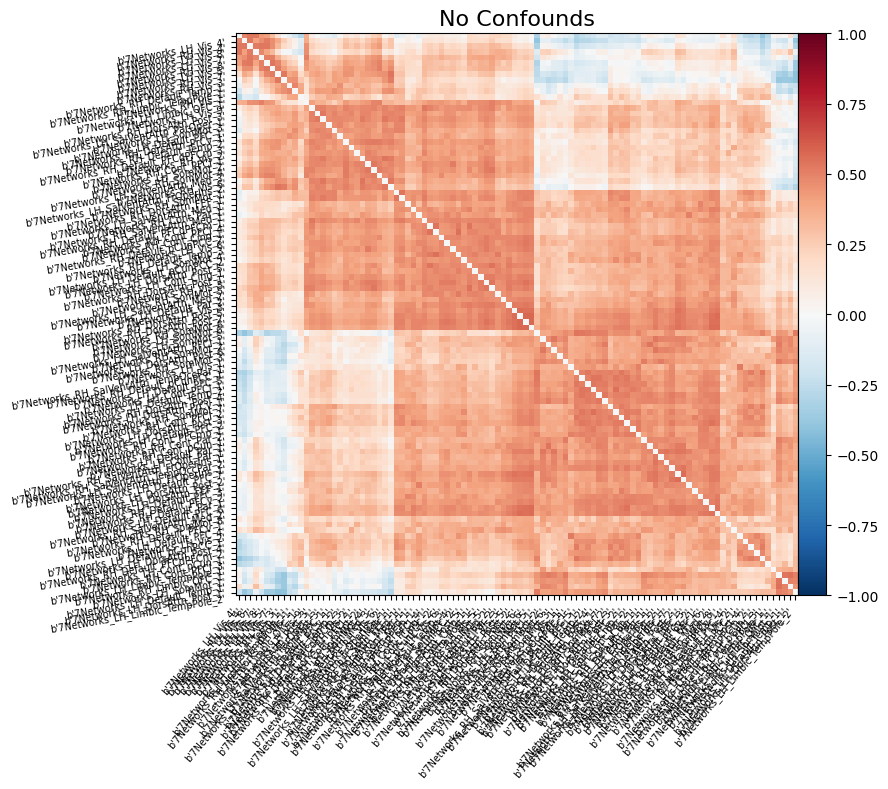

In [14]:
# Plot connectivity matrix - No Confounds

time_series = masker.fit_transform(FMRI_FILE_PATH)

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

print(correlation_matrix)

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=atlas_labels,
    vmax=1,
    vmin=-1,
    title="No Confounds",
    reorder=True,
)

The shape of the confounds matrix is: (140, 19)
Index(['cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05',
       'cosine06', 'cosine07', 'cosine08', 'cosine09', 'cosine10', 'csf',
       'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z',
       'white_matter'],
      dtype='object')
[NiftiLabelsMasker.wrapped] loading data from /Users/dyutichakraborty/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[Memory]396.8s, 6.6min  : Loading high_variance_confounds...
_____________________________high_variance_confounds cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('../../data/adni/sub-ADNI002S0295/ses-M060/func/sub-ADNI002S0295_ses-M060_task-rest_space-MNI152Lin_res-2_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x29a89db90>, { '

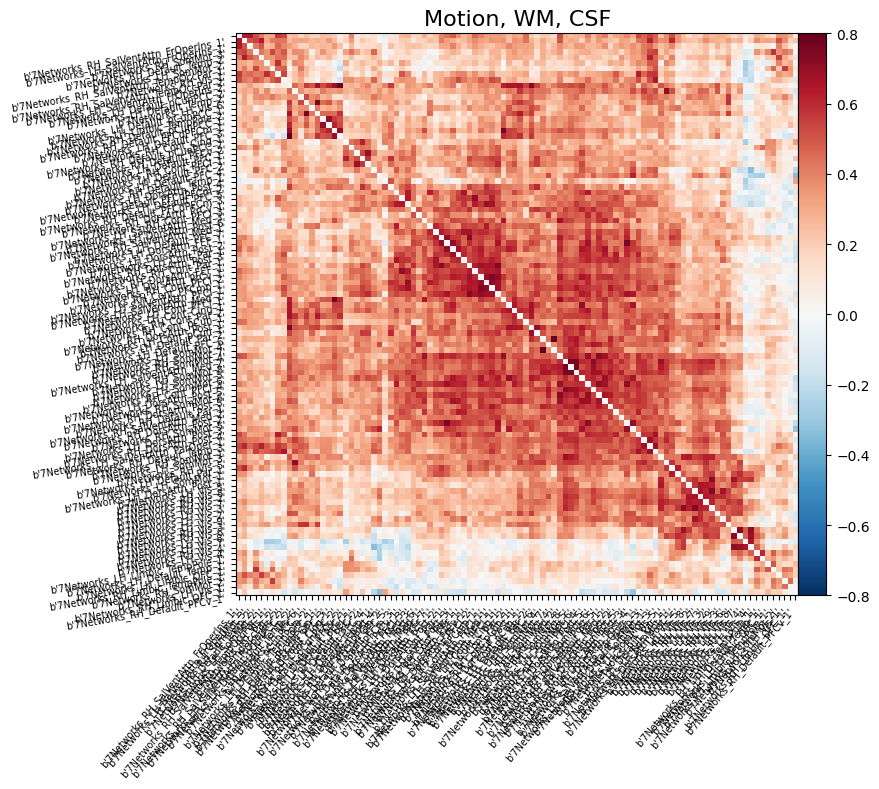

In [36]:
from nilearn.interfaces.fmriprep import load_confounds

confounds_simple, sample_mask = load_confounds(
    FMRI_FILE_PATH,
    strategy=["high_pass", "motion", "wm_csf"],
    motion="basic",
    wm_csf="basic",
)

print("The shape of the confounds matrix is:", confounds_simple.shape)
print(confounds_simple.columns)

time_series = masker.fit_transform(
    FMRI_FILE_PATH, confounds=confounds_simple, sample_mask=sample_mask
)

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=atlas_labels,
    vmax=0.8,
    vmin=-0.8,
    title="Motion, WM, CSF",
    reorder=True,
)